# Auxiliary Functions

In this section the auxiliary functions used in this project are implemented.

For this project, 2 Python helper modules were also implemented under jupyter/modules folder:

    - TextProcessor: Which has the methods to process the text using the approaches used in this project.
    - JsonHelper: It was used to convert dictionaries into JSON format.
    
The reason to separate these modules from the Jupyter notebooks was to keep the code organised and to follow the best programming practices with regards to reuse and code modularization.

In [18]:
# adding modules folder to the path
import sys
sys.path.append('./modules')

# importing constants and modules created for this project
from constants import *
from text_processor import *

# importing modules specific to this notebook
import logging
import pandas as pd
#import altair as alt
#import seaborn as sns
import random
import concurrent.futures
import matplotlib.pyplot as plt
import zipfile
from wordcloud import WordCloud
from dotenv import dotenv_values
from nltk.probability import FreqDist
from tqdm import tqdm
from datetime import datetime, timedelta
from IPython.display import Image

# use a logger to help debugging
logger = logging.getLogger('ca2-jupyter')

# set logger level
logger.setLevel(logging.ERROR)

def unzip_file(zip_path, extract_path):
    '''
    Auxiliary function to unzip files.

    Parameters:
        zip_path     (str): Zip file path.
        extract_path (str): Path to unzip.
    '''
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

def wordcloud_draw(data, color='black'):
    '''
    Auxiliary function to generate a word cloud from the data.

    Parameters:
        data (DataFrame): Data frame to be processed.
        color      (str): Background color.
    '''
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color, width=2500, height=2000).generate(words)
    wordcloud.to_file(join(IMAGES_FOLDER, TWEETS_WORD_CLOUD))
    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def process_tweets_chunk(chunk):
    """
    Auxiliary method to process the tweets from the input list.
    
    It processes the tweets, extracting their sentiment during the process.
    
    It generates a table with the following columns:

        'tweet_raw', 'sent_raw', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'
    
    Parameters:
        tweets_list (lst): List of tweets to be processed.
    Returns:
        tweets_df (DataFrame): Data frame with the processed data.
    """
    proc_tweets = []
    for tweet in chunk:
        tweet_raw = tweet
        sentiment_raw = TextProcessor.get_sentiment(tweet_raw)

        tweet_str = TextProcessor.clean_text(tweet_raw)
        sentiment_str = TextProcessor.get_sentiment(tweet_str)

        tweet_clr = TextProcessor.process_text(tweet_raw)
        sentiment_clr = TextProcessor.get_sentiment(tweet_clr)

        tweet_st = TextProcessor.process_text(tweet_raw, use_stemmer=True)
        sentiment_st = TextProcessor.get_sentiment(tweet_st)

        tweet_lm = TextProcessor.process_text(tweet_raw, use_lemmatizer=True)
        sentiment_lm = TextProcessor.get_sentiment(tweet_lm)

        proc_tweets.append((tweet_raw, sentiment_raw, tweet_str, sentiment_str, tweet_clr, sentiment_clr, tweet_st, sentiment_st, tweet_lm, sentiment_lm))

    return proc_tweets

def process_tweets_async(tweets_list, chunk_size=1000):
    """
    Auxiliary method to process the tweets async in chunks using the process_tweets_chunk function.
    
    It uses threads to process the block of tweets concurrently.
      
    Parameters:
        tweets_list (lst): List of tweets to be processed.
        chunk_size (int): The size of the chunks.
    Returns:
        tweets_df (DataFrame): Data frame with the processed data.
    """
    proc_tweets = []
    num_chunks = (len(tweets_list) + chunk_size - 1) // chunk_size

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for i in range(num_chunks):
            chunk = tweets_list[i*chunk_size:(i+1)*chunk_size]
            future = executor.submit(process_tweets_chunk, chunk)
            futures.append(future)

        for future in tqdm(concurrent.futures.as_completed(futures), total=num_chunks, desc='Processing'):
            proc_tweets.extend(future.result())

    tweets_df = pd.DataFrame(proc_tweets, columns=['tweet_raw', 'sent_raw', 'tweet_str', 'sent_str', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'])

    return tweets_df

def generate_one_year_random_dates(y=2022, num_dates=100):
    """
    Generate a DataFrame column with random dates covering one year period for the specified year.

    Parameters:
        y (year): The year to generate the random dates.
        num_dates (int): The number of random dates to generate.
    Returns:
        DataFrame: A DataFrame containing the randomly generated dates as a single column.
    """
    # set the start and end dates
    start_date = datetime(y, 1, 1)
    end_date = datetime(y, 12, 31)

    # generate random dates within the specified range
    random_dates = [start_date + timedelta(days=random.randint(0, 365)) for _ in range(num_dates)]

    # create a dataframe with the random dates
    df = pd.DataFrame({'RandomDates': random_dates})

    return df

# Sentiment Analysis

The dataset used was obtained from a <a href="https://www.kaggle.com/code/ssaisuryateja/eda-and-sentiment-analysis/input">Kaggle repository</a> and it is about Twitter's users comments on the war in Ukraine in 2022.

This large dataset was processed for sentiment analysis and time-series to forcast the sentiment of tweets over a period of time.

The following sections cover the EDA steps and the sentiment and time-series analysis.

## Data Pre-Processing

In this step the raw data is collected from the csv file in the datasets folder.

It was handled duplicates, and the columns were properly converted into their data types.

In [21]:
# zip files with the dataset
tweets_raw_zip = join(DATASETS_FOLDER, 'tweets_raw.zip')
tweets_sent_zip = join(DATASETS_FOLDER, 'tweets_sentiment.zip')

# unzip the files
unzip_file(tweets_raw_zip, DATASETS_FOLDER)
unzip_file(tweets_sent_zip, DATASETS_FOLDER)

In [22]:
# getting tweets from the archive
dataset = pd.read_csv(TWEETS_DS_RAW, encoding='utf-8')

# dataset column names
tweets_cols = ['username', 'tweetid', 'text', 'hashtags', 'language', 'extractedts']

# storing the dataset in a variable for processing
tweets_df = dataset[tweets_cols]

# converting date column into proper date type
tweets_df['extractedts'] = pd.to_datetime(tweets_df['extractedts'])

# data size
print(f'Dataset size: {len(tweets_df)}')

Dataset size: 364875


In [23]:
# checking for null values
pd.DataFrame(tweets_df.isnull().sum(), columns=['Null Values'])

,Null Values
username,0
tweetid,0
text,0
hashtags,0
language,0
extractedts,0


In [24]:
# describing the data
tweets_df.describe(include='all')

,username,tweetid,text,hashtags,language,extractedts
count,364875,3.648750e+05,364875,364875,364875,364875
unique,166400,NaN,104548,85962,61,364875
top,FuckPutinBot,NaN,⚡The Ukrainian Air Force would like to address...,[],en,2022-04-01 00:44:20.097867
freq,789,NaN,7297,72345,254626,1
first,NaN,NaN,NaN,NaN,NaN,2022-04-01 00:01:44.294934
last,NaN,NaN,NaN,NaN,NaN,2022-04-02 00:46:57.116538
mean,NaN,1.509875e+18,NaN,NaN,NaN,NaN
std,NaN,9.829062e+13,NaN,NaN,NaN,NaN
min,NaN,1.509682e+18,NaN,NaN,NaN,NaN
25%,NaN,1.509795e+18,NaN,NaN,NaN,NaN


The original dataset covers only a short period of time as shown below.

In [25]:
# showing the date covereage in this dataset
tweets_df['extractedts'].min(), tweets_df['extractedts'].max()

(Timestamp('2022-04-01 00:01:44.294934'),
 Timestamp('2022-04-02 00:46:57.116538'))

This way, for the sake of the experimentation proposed in the brief of this project, the date column will be edited to cover the period of one year.

The strategy used for this was to generate random dates that cover the whole year of 2022.

In [26]:
# generate random dates covering the period of one year
random_dates_column = generate_one_year_random_dates(2022, len(tweets_df))

# displaying the first entries
random_dates_column.head()

,RandomDates
0,2022-10-03
1,2022-05-23
2,2022-06-26
3,2022-08-08
4,2022-04-28


## Text Processing for Sentiment Analysis

For this project, the raw tweets were processed and the following columns were generated:

    tweet_raw, sent_raw: Original tweets + sentiment.

    tweet_str, sent_str: Tweets after the removal of special characters + sentiment.

    tweet_clr, sent_clr: Tweets after the removal of special characters and stop words + sentiment.

    tweet_st, sent_st: Tweets after the removal of special characters, stop words and application of Porter Stemmer + sentiment.

    tweet_lm, sent_lm: Tweets after the removal of special characters, stop words and application of Lemmatizer + sentiment.

The sentiment was calculated for each version of the tweet because it was observed the results were different.

The algorithm used to extract the sentiment from the Tweets were obtained from TextBlob. The possible sentiments were: positive, negative and neutral.

Since this is a time consuming process, the tweets were processed previously and stored in a csv file in the datasets folder.

So, the next code block can be skipped as the processed tweets will be obtained directly from the csv file.

In [70]:
# NOTE: YOU CAN SKIP THIS CODE BLOCK.
# ONLY RUN THIS CODE IF YOU WANT TO RE-CALCULATE THE SENTIMENT OF THE RAW TWEETS
# THIS IS TIME-CONSUMING SO EVEN WITH A MULTI-THREAD STRATEGY TO PROCESS THE TWEETS 
# IN CHUNKS IT TAKES A LONG TIME TO FINISH.

# getting the tweets list from the dataframe
tweets_list = tweets_df['text'].values

# processing retrieved data using text processing
tweets_proc = process_tweets_async(tweets_list)

# creating a csv file in the output folder for the full dataset
tweets_proc.to_csv(TWEETS_SENT, index=False)

# display the first rows
tweets_proc.head()

Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [53:19<00:00,  8.77s/it]


,tweet_raw,sent_raw,tweet_str,sent_str,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm
0,#Ukraine: Another Russian BTR-82A lost during ...,neutral,ukraine another russian btr a lost during u...,neutral,ukraine another russian btr lost ukrainian adv...,neutral,ukrain anoth russian btr lost ukrainian advanc...,neutral,ukraine another russian btr lost ukrainian adv...,neutral
1,#Biden's plan would be accompanied by a diplom...,negative,biden s plan would be accompanied by a diploma...,negative,biden plan would accompanied diplomatic push i...,neutral,biden plan would accompani diplomat push inter...,neutral,biden plan would accompanied diplomatic push i...,neutral
2,(1/3) 🇷🇺🇮🇹 Il 30 marzo 2022 su iniziativa dell...,neutral,il marzo su iniziativa dell...,neutral,il marzo su iniziativa della parte italiana si...,neutral,il marzo su iniziativa della part italiana si ...,neutral,il marzo su iniziativa della parte italiana si...,neutral
3,"@Abiy Ahmed, Eritrean dictator Isaias Afewerki...",neutral,ahmed eritrean dictator isaias afewerki and ...,neutral,ahmed eritrean dictator isaias afewerki amhara...,neutral,ahm eritrean dictat isaia afewerki amhara alli...,positive,ahmed eritrean dictator isaias afewerki amhara...,neutral
4,I’m on a longer assignment in #Warsaw #Poland ...,neutral,i m on a longer assignment in warsaw poland co...,neutral,longer assignment warsaw poland covering refug...,neutral,longer assign warsaw poland cover refuge ukrai...,neutral,long assignment warsaw poland covering refugee...,negative


In [27]:
# getting tweets from the archive
tweets_proc = pd.read_csv(TWEETS_SENT, encoding='utf-8')

# size of the data
print(f'{len(tweets_proc)}')

# display the first rows
tweets_proc.head()

364875


,tweet_raw,sent_raw,tweet_str,sent_str,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm
0,#Ukraine: Another Russian BTR-82A lost during ...,neutral,ukraine another russian btr a lost during u...,neutral,ukraine another russian btr lost ukrainian adv...,neutral,ukrain anoth russian btr lost ukrainian advanc...,neutral,ukraine another russian btr lost ukrainian adv...,neutral
1,#Biden's plan would be accompanied by a diplom...,negative,biden s plan would be accompanied by a diploma...,negative,biden plan would accompanied diplomatic push i...,neutral,biden plan would accompani diplomat push inter...,neutral,biden plan would accompanied diplomatic push i...,neutral
2,(1/3) 🇷🇺🇮🇹 Il 30 marzo 2022 su iniziativa dell...,neutral,il marzo su iniziativa dell...,neutral,il marzo su iniziativa della parte italiana si...,neutral,il marzo su iniziativa della part italiana si ...,neutral,il marzo su iniziativa della parte italiana si...,neutral
3,"@Abiy Ahmed, Eritrean dictator Isaias Afewerki...",neutral,ahmed eritrean dictator isaias afewerki and ...,neutral,ahmed eritrean dictator isaias afewerki amhara...,neutral,ahm eritrean dictat isaia afewerki amhara alli...,positive,ahmed eritrean dictator isaias afewerki amhara...,neutral
4,I’m on a longer assignment in #Warsaw #Poland ...,neutral,i m on a longer assignment in warsaw poland co...,neutral,longer assignment warsaw poland covering refug...,neutral,longer assign warsaw poland cover refuge ukrai...,neutral,long assignment warsaw poland covering refugee...,negative


## Combine the Dataset

In this step the dataset is combined so all the tweets have their sentiment and the date allocated properly.

In [28]:
len(tweets_df), len(tweets_proc), len(random_dates_column)

(364875, 364875, 364875)

In [29]:
# concatenate the sentiment and the original dataset
tweets_final = pd.concat([tweets_df, tweets_proc, random_dates_column], axis=1)

print(f'{len(tweets_final)}')

# independent variables to be tested from the dataset
X_names = ['tweet_str', 'tweet_clr', 'tweet_st', 'tweet_lm']
# target variables for each column to be tested
y_names = ['sent_str', 'sent_clr', 'sent_st', 'sent_lm']
# ramdom date
col_date = ['RandomDates']

# keeping only the relevant columns for the analysis
col_names = X_names + y_names + col_date
tweets_final = tweets_final[col_names]
tweets_final.head()

364875


,tweet_str,tweet_clr,tweet_st,tweet_lm,sent_str,sent_clr,sent_st,sent_lm,RandomDates
0,ukraine another russian btr a lost during u...,ukraine another russian btr lost ukrainian adv...,ukrain anoth russian btr lost ukrainian advanc...,ukraine another russian btr lost ukrainian adv...,neutral,neutral,neutral,neutral,2022-10-03
1,biden s plan would be accompanied by a diploma...,biden plan would accompanied diplomatic push i...,biden plan would accompani diplomat push inter...,biden plan would accompanied diplomatic push i...,negative,neutral,neutral,neutral,2022-05-23
2,il marzo su iniziativa dell...,il marzo su iniziativa della parte italiana si...,il marzo su iniziativa della part italiana si ...,il marzo su iniziativa della parte italiana si...,neutral,neutral,neutral,neutral,2022-06-26
3,ahmed eritrean dictator isaias afewerki and ...,ahmed eritrean dictator isaias afewerki amhara...,ahm eritrean dictat isaia afewerki amhara alli...,ahmed eritrean dictator isaias afewerki amhara...,neutral,neutral,positive,neutral,2022-08-08
4,i m on a longer assignment in warsaw poland co...,longer assignment warsaw poland covering refug...,longer assign warsaw poland cover refuge ukrai...,long assignment warsaw poland covering refugee...,neutral,neutral,neutral,negative,2022-04-28


In [30]:
# checking for null values
pd.DataFrame(tweets_final.isnull().sum(), columns=['Null Values'])

,Null Values
tweet_str,0
tweet_clr,2
tweet_st,2
tweet_lm,2
sent_str,0
sent_clr,0
sent_st,0
sent_lm,0
RandomDates,0


In [31]:
# removing null values
tweets_final = tweets_final.dropna()

# checking for null values
pd.DataFrame(tweets_final.isnull().sum(), columns=['Null Values'])

,Null Values
tweet_str,0
tweet_clr,0
tweet_st,0
tweet_lm,0
sent_str,0
sent_clr,0
sent_st,0
sent_lm,0
RandomDates,0


## Tweets Dataset Visualization

Word cloud are common ways to visualize text datasets, so it is possible to have an idea of its main content.

The word cloud below was generated over the cleaned tweets after the removal of special characters and stop words.

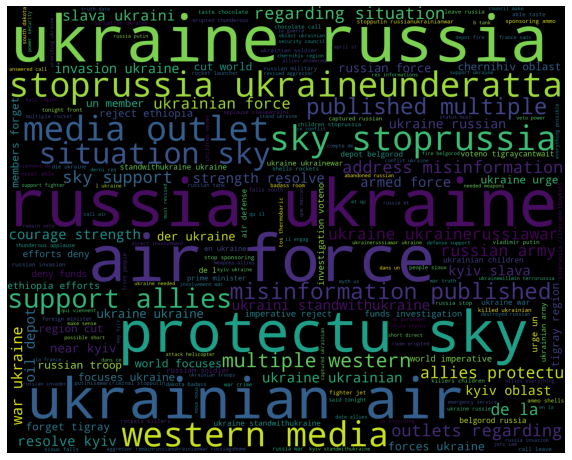

In [15]:
#wordcloud_draw(tweets_final['tweet_clr'])
Image(filename=join(IMAGES_FOLDER, TWEETS_WORD_CLOUD))